In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, RobustScaler, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_curve, 
    auc, 
    RocCurveDisplay
)
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [10]:
plt.style.use("default")
sns.set_palette("Set2")

RANDOM_STATE = 42
TARGET_COL = "Status"
DROP_COL = ["id", "N_Days"]

Признак N_Days исключён, поскольку он приводит к ликам. Это значение всегда указывается постфактум вместе с таргетом. Если наша цель — создание "честной" медицинской ML-модели, то на момент прогнозирования вероятности исхода заболевания мы ничего не знаем о том, сколько дней проживёт пациент.

# Этап I. Предобработка данных для ML

Загрузим данные, разделим наши признаки на числовые и категориальные, преобразуем таргет в бинарный, разделим на train и test.

In [12]:
df = pd.read_csv("../../data/train.csv").drop(columns=DROP_COL)

In [13]:
# убираем статус CL - "трансплантация печени"
target_maps = {"C": 0, "D": 1}

binary_maps = {
    "Drug": {"Placebo": 0, "D-penicillamine": 1},
    "Sex": {"F": 0, "M": 1},
    "Ascites": {"N": 0, "Y": 1},
    "Hepatomegaly": {"N": 0, "Y": 1},
    "Spiders": {"N": 0, "Y": 1}
}

binary_features = list(binary_maps.keys())
multi_category_features = ["Edema", "Stage"]

numeric_features = ["Age", "Bilirubin", "Cholesterol", "Albumin", "Copper",
                    "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", "Prothrombin"]

skewed_numeric = ["Bilirubin", "Cholesterol", "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Prothrombin"]

symmetric_numeric = [col for col in numeric_features if col not in skewed_numeric]

Исходный таргет с тремя категориями преобразуем в две путем удаления объектов со статусом CL (пересадка печени), т.к. их всего 3% от общего количества. Объединять его с классом C (пациент жив) или D (летальный исход) не совсем верно. Т.о. убираем дисбаланс класса и получаем следующую картину:

- Класс 0, умеренная стадия заболевания — C (пациент жив)
- Класс 1, тяжёлая стадия заболевания — D (летальный исход)

In [14]:
# Удаляем строки CL и преобразовываем
df = df[df[TARGET_COL] != "CL"]
df[TARGET_COL] = df[TARGET_COL].map(target_maps)

Тем не менее все еще наблюдаем выраженный дисбаланс классов: только более трети пациентов страдают тяжёлой формой заболевания. Это будет учтено при обучении ML-модели и оценке качества.  

In [15]:
df[TARGET_COL].value_counts(normalize=True)

Status
0    0.650721
1    0.349279
Name: proportion, dtype: float64

Разделим все данные на train и test. Подбор методов обработки признаков, настройку гиперпараметров и оценку качества будем проводить только на кросс-валидации на train. Test служит для финальной оценки качества лучшей модели.

In [16]:
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

In [17]:
print("Распределение таргета на train:")
print(y_train.value_counts(normalize=True))

print("=="*25)

print("Распределение таргета на test:")
print(y_test.value_counts(normalize=True))

Распределение таргета на train:
Status
0    0.650721
1    0.349279
Name: proportion, dtype: float64
Распределение таргета на test:
Status
0    0.650721
1    0.349279
Name: proportion, dtype: float64


Напишем классы-преобразователи для переменных разных типов.

In [18]:
class BinaryMapper(BaseEstimator, TransformerMixin):
    """
    Превращает бинарные категориальные в 0/1 по заданному словарю.
    """
    def __init__(self, mapping: dict):
        self.mapping = mapping
        self.columns_ = list(mapping.keys())

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_df = X.copy() if isinstance(X, pd.DataFrame) else pd.DataFrame(X, columns=self.columns_)
        for col, mapping in self.mapping.items():
            X_df[col] = X_df[col].map(mapping)
        return X_df

    def get_feature_names_out(self, input_features=None):
        return self.columns_


class PercentileClipper(BaseEstimator, TransformerMixin):
    """Обрезает выбросы в указанных колонках по перцентилям."""
    def __init__(self, columns, lower=0.0, upper=99.5):
        self.columns = columns
        self.lower = lower
        self.upper = upper
        self.bounds_ = {}

    def fit(self, X, y=None):
        X = pd.DataFrame(X, columns=self.columns)
        for col in self.columns:
            low = np.percentile(X[col], self.lower)
            up = np.percentile(X[col], self.upper)
            self.bounds_[col] = (low, up)
        return self

    def transform(self, X):
        X_df = pd.DataFrame(X, columns=self.columns)
        for col, (low, up) in self.bounds_.items():
            X_df[col] = X_df[col].clip(low, up)
        return X_df.values

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return np.array(self.columns, dtype=object)
        return np.asarray(input_features, dtype=object)

Создадим несколько пайплайнов с разными видами преобразований, из которых затем выберем лучший.

Ниже указаны 3 стратегии предобработки числовых признаков, которые имеют выбросы:

- Вариант 1: log
- Вариант 2: percentile clip
- Вариант 3: log + percentile clip

**Log-преобразование** стабилизирует дисперсию и уменьшает асимметрию, делает данные более нормальными.

**Percentile Clipper** обрезает экстремальные выбросы по перцентилям (в нашем случае — длинные правые хвосты), защищает от сильного влияния аномалий.

In [19]:
def make_preprocessor(strategy="log"):

    log = FunctionTransformer(np.log1p, feature_names_out="one-to-one")

    # Вариант 1: log
    if strategy == "log":
        skewed_pipe = Pipeline([
            ("log", log)
        ])

    # Вариант 2: percentile clip
    elif strategy == "clip":
        skewed_pipe = Pipeline([
            ("clip", PercentileClipper(skewed_numeric, upper=99)),
        ])

    # Вариант 3: log + percentile clip
    elif strategy == "log_clip":
        skewed_pipe = Pipeline([
            ("log", log),
            ("clip", PercentileClipper(skewed_numeric, upper=99))
        ])

    else:
        raise ValueError(f"Unknown strategy: {strategy}")

    preprocessor = ColumnTransformer(
        transformers=[
            ("num_skewed", skewed_pipe, skewed_numeric),
            ("num_symmetric", "passthrough", symmetric_numeric),
            ("binary", BinaryMapper(binary_maps), binary_features),
            ("category", OrdinalEncoder(), multi_category_features)
        ],
        remainder="drop",
        verbose_feature_names_out=False
    )

    return preprocessor

Применим разные стратегии преобразования к X_train, чтобы затем сравнить их между собой.

In [20]:
STRATEGIES = ["log", "clip", "log_clip"]

def apply_strategies(X_train, strategies=STRATEGIES):
    outputs = {}
    for s in strategies:
        processor = make_preprocessor(s)
        X_proc = processor.fit_transform(X_train)
        cols = processor.get_feature_names_out()
        outputs[s] = pd.DataFrame(X_proc, columns=cols, index=X_train.index)
    return outputs

In [21]:
processed = apply_strategies(X_train)

Теперь выберем наиболее подходящий метод с помощью визуализаций.

In [22]:
def plot_skewed_changes(X_train, processed, features=skewed_numeric, bins=30):
    """
    Для каждого skewed признака:
    - слева оригинал
    - справа - версии после разных стратегий
    """
    n = len(features)
    fig, axes = plt.subplots(n, 1 + len(processed), figsize=(5*(1+len(processed)), 3*n), squeeze=False)

    for i, col in enumerate(features):
        ax = axes[i, 0]
        sns.histplot(X_train[col], bins=bins, ax=ax)
        ax.set_title(f"{col} (до)")

        for j, s in enumerate(processed.keys(), start=1):
            ax = axes[i, j]
            sns.histplot(processed[s][col], bins=bins, ax=ax)
            ax.set_title(f"{col} — {s}")

    plt.tight_layout()
    plt.show()


def plot_boxplots(X_train, processed, features=skewed_numeric):
    n = len(features)
    fig, axes = plt.subplots(n, 1+len(processed), figsize=(5*(1+len(processed)), 2.5*n), squeeze=False)

    for i, col in enumerate(features):
        axes[i, 0].boxplot(X_train[col], vert=True)
        axes[i, 0].set_title(f"{col} (до)")

        for j, s in enumerate(processed.keys(), start=1):
            axes[i, j].boxplot(processed[s][col].dropna(), vert=True)
            axes[i, j].set_title(f"{col} — {s}")

    plt.tight_layout()
    plt.show()


def summarize_changes(X_train, processed, numeric_features=numeric_features):
    print("\n=== СВОДКА ТРАНСФОРМАЦИЙ ЧИСЛОВЫХ ПРИЗНАКОВ ===\n")

    for col in numeric_features:
        print(f"\nПРИЗНАК: {col}")
        print(f"  • исходный skew: {X_train[col].skew():.2f}")

        for strat, df_proc in processed.items():
            s = df_proc[col]
            skew = s.skew()
            z = (s - s.mean()) / (s.std() + 1e-9)
            out = (np.abs(z) > 3).mean()

            print(f"    - {strat}: skew={skew:.2f}, доля выбросов(|z|>3)={out:.3f}")

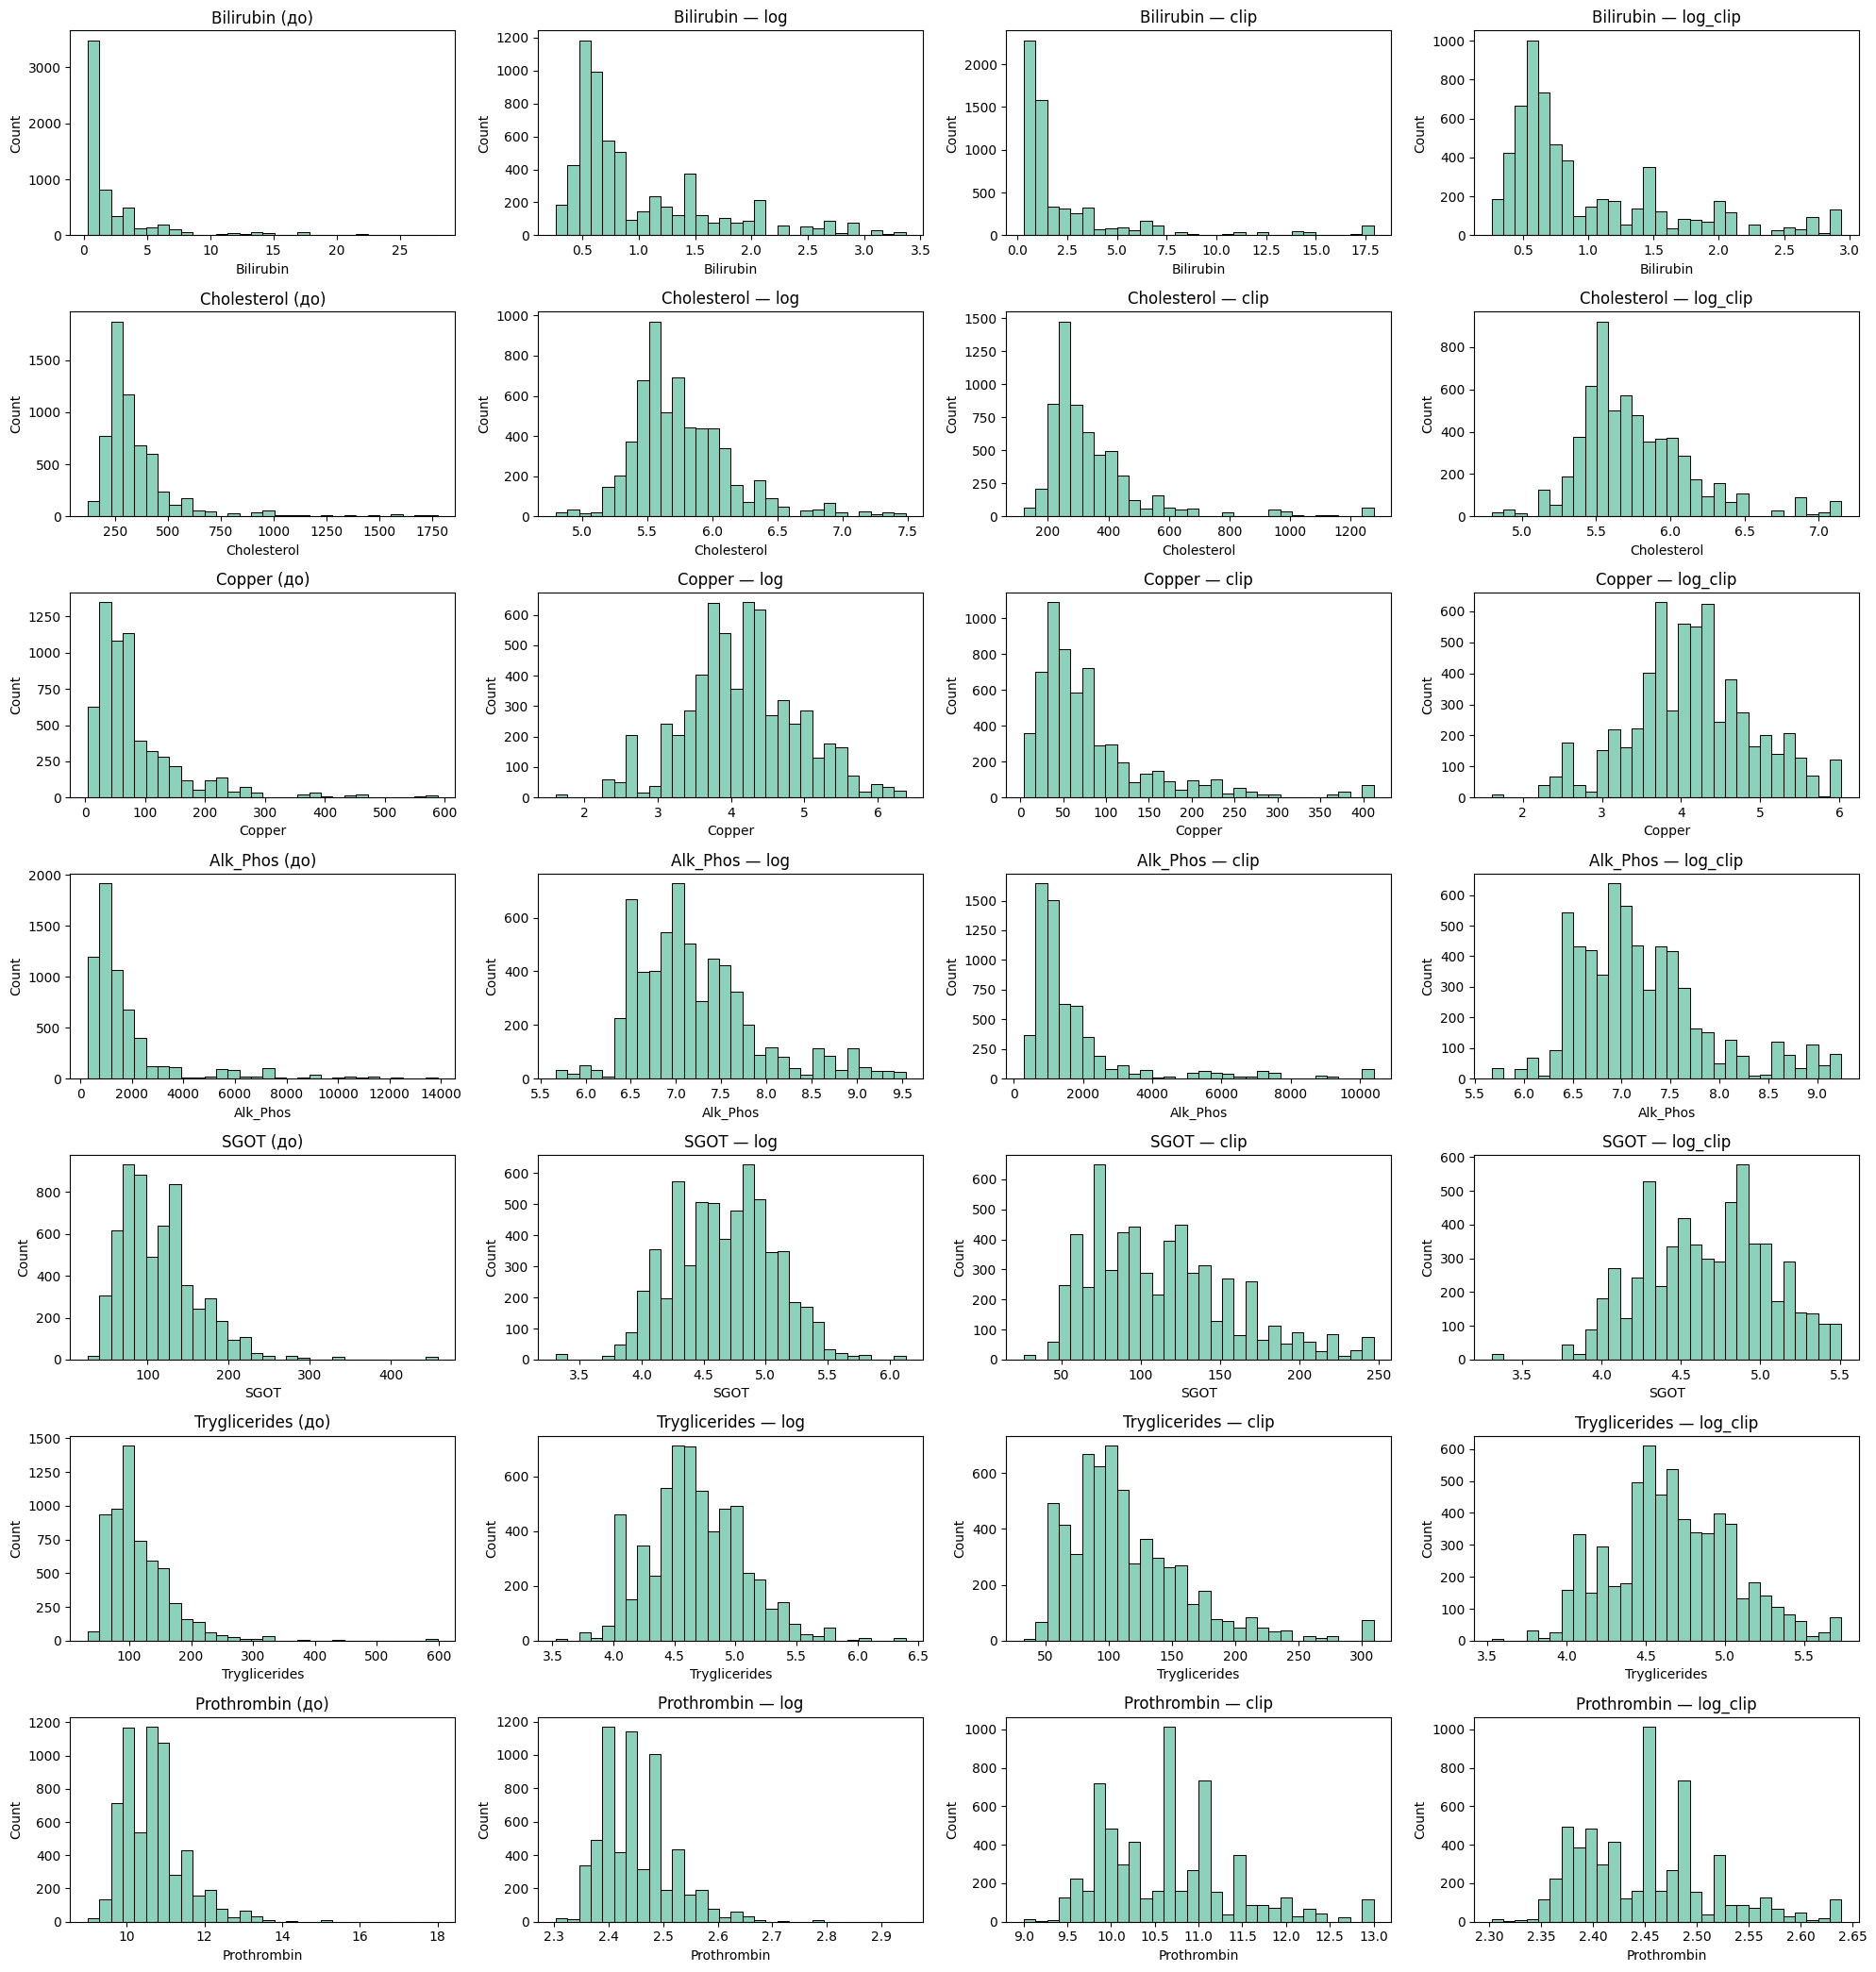

In [23]:
plot_skewed_changes(X_train, processed)

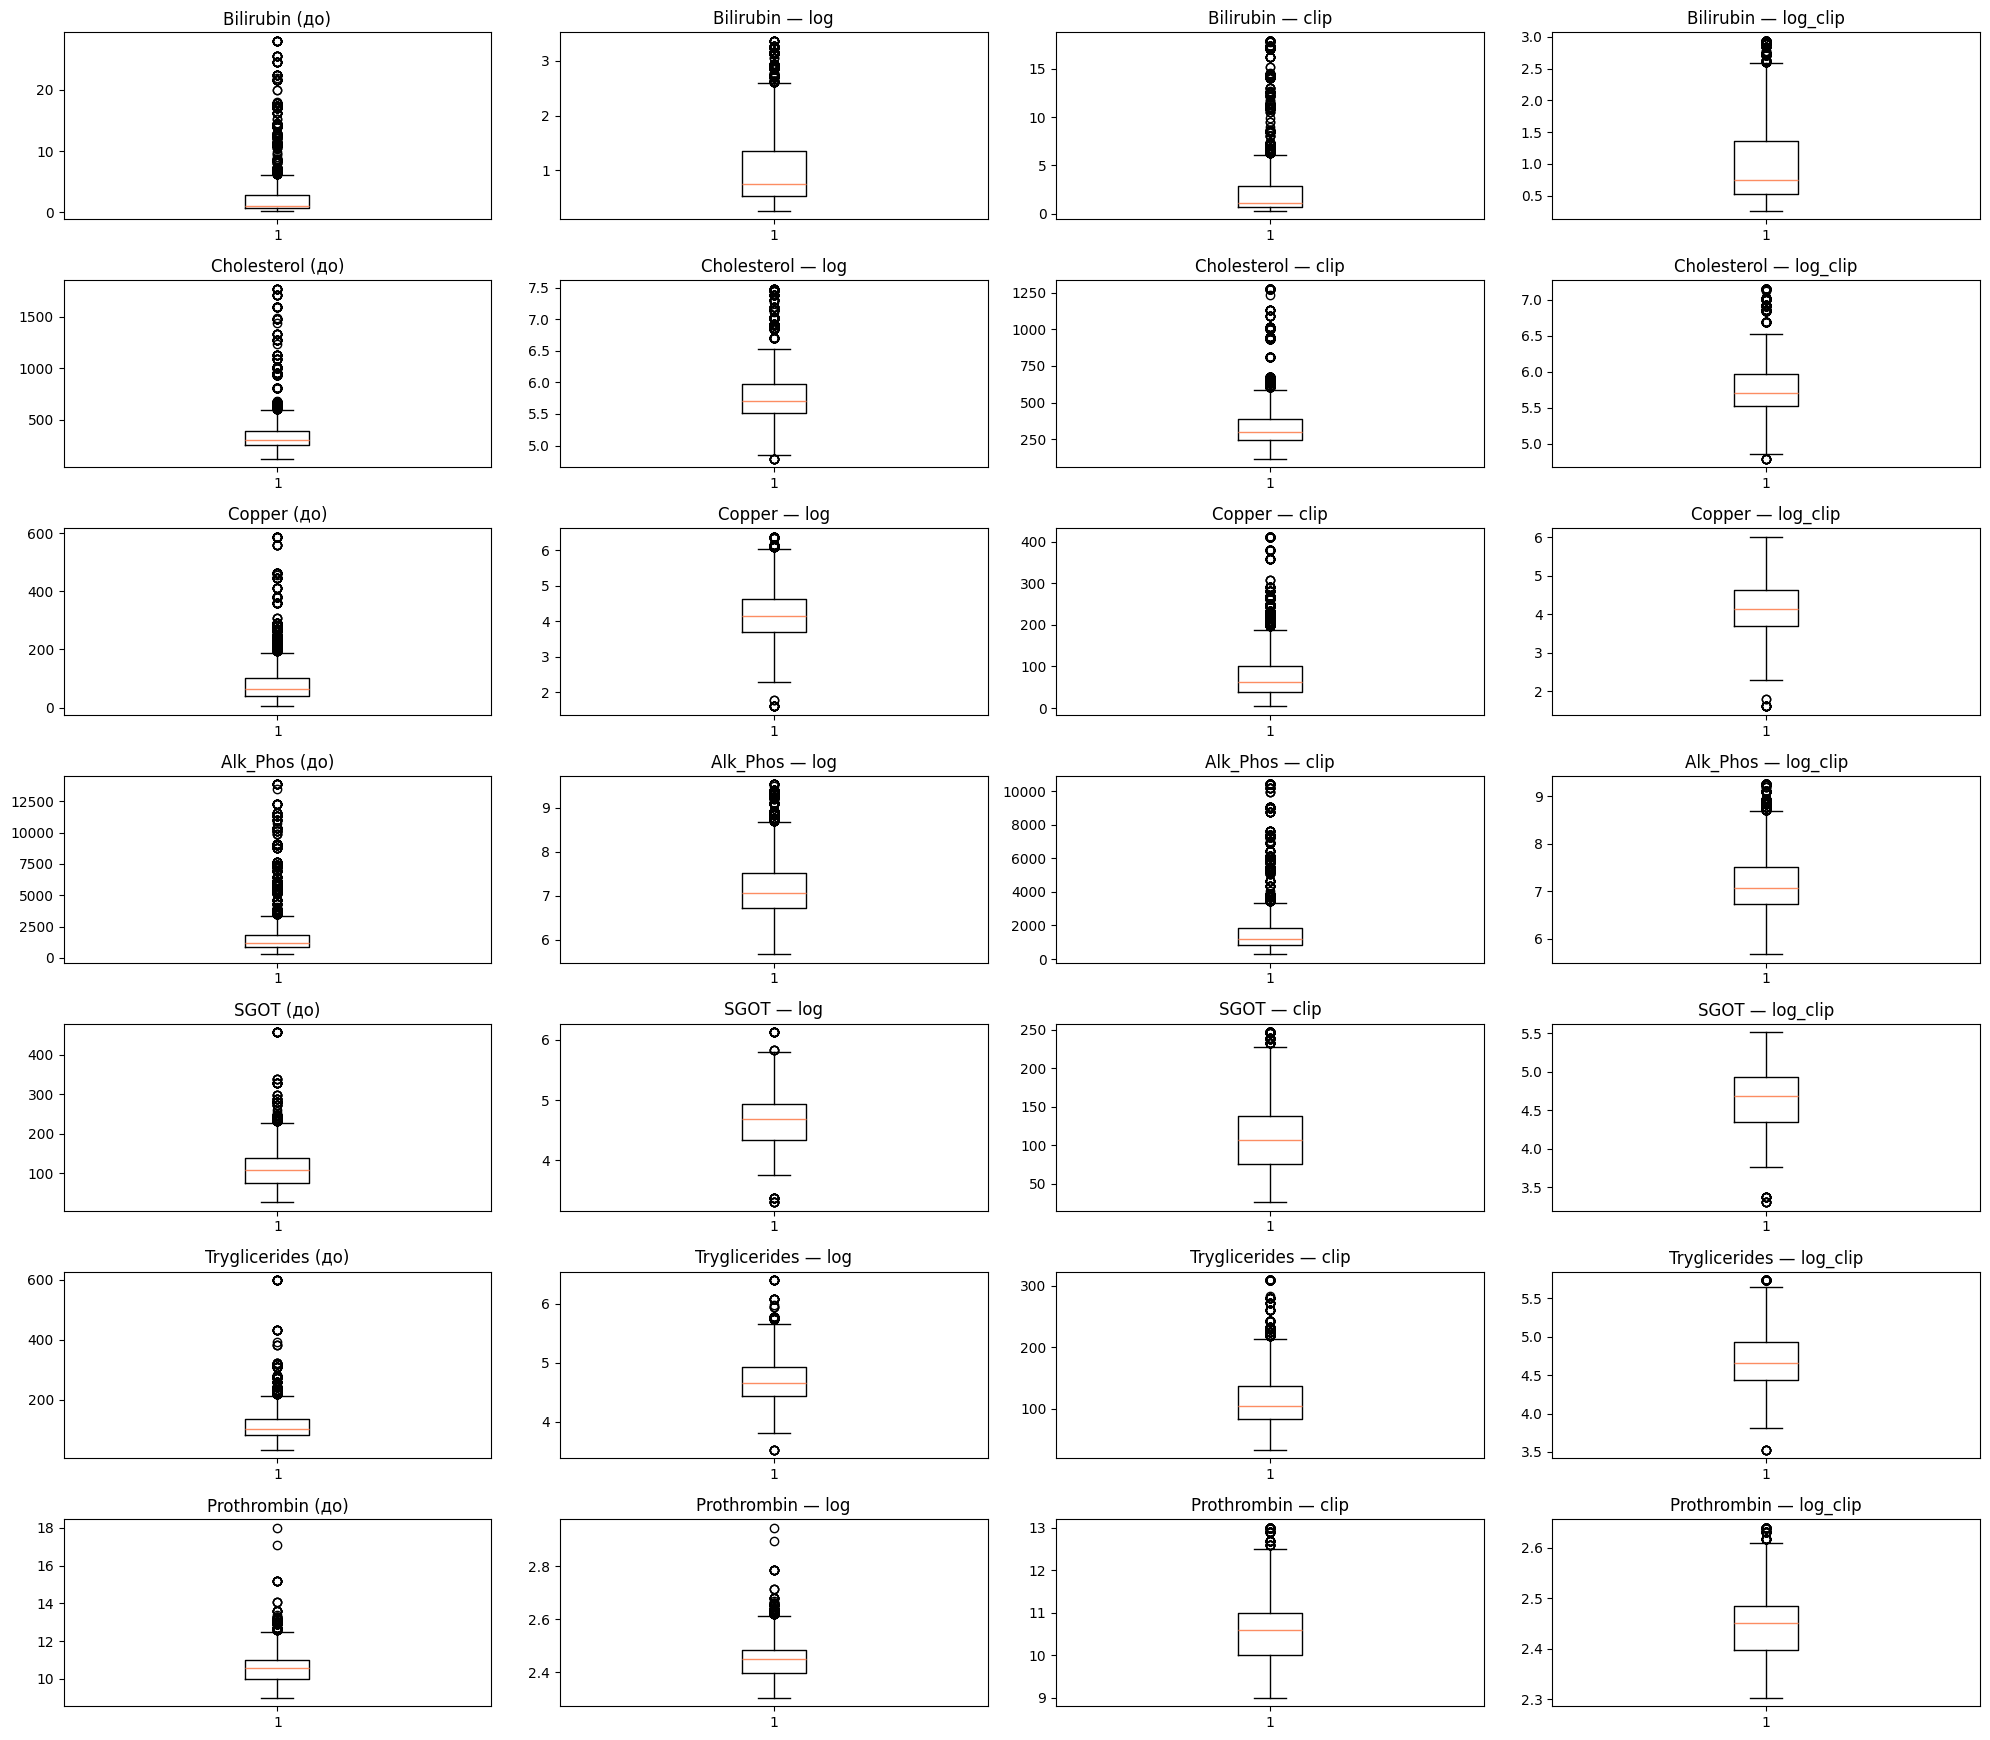

In [24]:
plot_boxplots(X_train, processed)

In [25]:
summarize_changes(X_train, processed)


=== СВОДКА ТРАНСФОРМАЦИЙ ЧИСЛОВЫХ ПРИЗНАКОВ ===


ПРИЗНАК: Age
  • исходный skew: 0.07
    - log: skew=0.07, доля выбросов(|z|>3)=0.000
    - clip: skew=0.07, доля выбросов(|z|>3)=0.000
    - log_clip: skew=0.07, доля выбросов(|z|>3)=0.000

ПРИЗНАК: Bilirubin
  • исходный skew: 3.30
    - log: skew=1.44, доля выбросов(|z|>3)=0.010
    - clip: skew=2.81, доля выбросов(|z|>3)=0.039
    - log_clip: skew=1.38, доля выбросов(|z|>3)=0.012

ПРИЗНАК: Cholesterol
  • исходный skew: 3.63
    - log: skew=1.26, доля выбросов(|z|>3)=0.015
    - clip: skew=2.90, доля выбросов(|z|>3)=0.032
    - log_clip: skew=1.12, доля выбросов(|z|>3)=0.017

ПРИЗНАК: Albumin
  • исходный skew: -0.58
    - log: skew=-0.58, доля выбросов(|z|>3)=0.015
    - clip: skew=-0.58, доля выбросов(|z|>3)=0.015
    - log_clip: skew=-0.58, доля выбросов(|z|>3)=0.015

ПРИЗНАК: Copper
  • исходный skew: 2.71
    - log: skew=0.06, доля выбросов(|z|>3)=0.002
    - clip: skew=2.20, доля выбросов(|z|>3)=0.020
    - log_clip: skew=0.0

Для числовых признаков выберем стратегию log_clip:

*   Сочетает преимущества log-преобразования и борьбы с выбросами

*   Лучшие показатели по снижению асимметрии для большинства признаков

*   Уменьшает влияние выбросов без потери информации

*   Более стабильные результаты на реальных данных

# Этап II. Применение дерева решений

Инициализируем выбранный метод предобработки.

In [26]:
preprocessor = make_preprocessor("log_clip")

Посмотрим, как будет выглядеть предобработанный датасет после указанных выше преобразований.

In [27]:
df_proc = pd.DataFrame(preprocessor.fit_transform(X_train), columns=preprocessor.get_feature_names_out())

In [28]:
df_proc.head()

,Bilirubin,Cholesterol,Copper,Alk_Phos,SGOT,Tryglicerides,Prothrombin,Age,Albumin,Platelets,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema,Stage
0,1.223775,6.304449,4.762174,7.173192,4.998900,4.990433,2.459589,12227.0,3.60,291.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.470004,5.888878,3.970292,7.137278,5.019595,5.241747,2.388763,18499.0,3.90,178.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0
2,2.912351,5.170484,6.023448,6.673298,5.214392,5.257495,2.639057,17031.0,2.75,190.0,0.0,0.0,1.0,1.0,1.0,2.0,3.0
3,2.610070,5.808142,4.465908,7.308543,4.911551,4.644391,2.484907,16839.0,3.60,277.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0
4,2.041220,5.926926,4.644391,6.887553,4.864839,4.615121,2.493205,18713.0,3.74,266.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [29]:
df_proc.describe().T

,count,mean,std,min,25%,50%,75%,max
Bilirubin,6104.0,0.989017,0.642046,0.262364,0.530628,0.741937,1.360977,2.939162
Cholesterol,6104.0,5.763669,0.381746,4.795791,5.517453,5.700444,5.968708,7.152269
Copper,6104.0,4.136229,0.765356,1.609438,3.688879,4.143135,4.624973,6.023448
Alk_Phos,6104.0,7.206874,0.677359,5.669881,6.727432,7.069023,7.518064,9.249350
SGOT,6104.0,4.662219,0.397437,3.308717,4.343156,4.681668,4.934114,5.511209
Tryglicerides,6104.0,4.671546,0.383630,3.526361,4.442651,4.653960,4.927254,5.736572
Prothrombin,6104.0,2.451052,0.063408,2.302585,2.397895,2.451005,2.484907,2.639057
Age,6104.0,18420.344201,3685.059634,9598.000000,15601.000000,18719.000000,20684.000000,28650.000000
Albumin,6104.0,3.547526,0.346344,1.960000,3.350000,3.580000,3.770000,4.640000
Platelets,6104.0,265.294233,86.734217,62.000000,212.000000,265.000000,317.000000,563.000000


Будем использовать StratifiedKFold, чтобы в каждом фолде была соблюдена пропорция классов. Установим 5 фолдов.

In [30]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

## 1. Baseline

В качестве базового варианта попробуем модель дерево решений (decision tree)

In [31]:
dt_base_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("dt", DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid_dt = {
    'dt__max_depth': [3, 5, 7, 10, 15, None],
    'dt__min_samples_split': [2, 5, 10, 20],
    'dt__min_samples_leaf': [1, 2, 4, 8],
    'dt__max_leaf_nodes': [10, 20, 50, 100, None],
    'dt__criterion': ['gini', 'entropy'],
    'dt__class_weight': [None, 'balanced']
}

gs_dt_base = GridSearchCV(
    dt_base_pipeline,
    param_grid=param_grid_dt,
    cv=skf,
    scoring="recall",
    n_jobs=-1
)

gs_dt_base.fit(X_train, y_train)
print("Базовая дерево решений (без учёта дисбаланса)")
print("Лучшие параметры:", gs_dt_base.best_params_)
print("Лучший recall на кросс-валидации:", gs_dt_base.best_score_)

Базовая дерево решений (без учёта дисбаланса)
Лучшие параметры: {'dt__class_weight': 'balanced', 'dt__criterion': 'gini', 'dt__max_depth': 7, 'dt__max_leaf_nodes': 50, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 20}
Лучший recall на кросс-валидации: 0.7884674165209838


In [32]:
y_pred_dt_base = cross_val_predict(
    gs_dt_base.best_estimator_,
    X_train, y_train,
    cv=skf,
    n_jobs=-1
)

print("Отчёт по классам (базовая модель без учёта дисбаланса):")
print(classification_report(y_train, y_pred_dt_base))

Отчёт по классам (базовая модель без учёта дисбаланса):
              precision    recall  f1-score   support

           0       0.87      0.79      0.83      3972
           1       0.67      0.79      0.72      2132

    accuracy                           0.79      6104
   macro avg       0.77      0.79      0.78      6104
weighted avg       0.80      0.79      0.79      6104



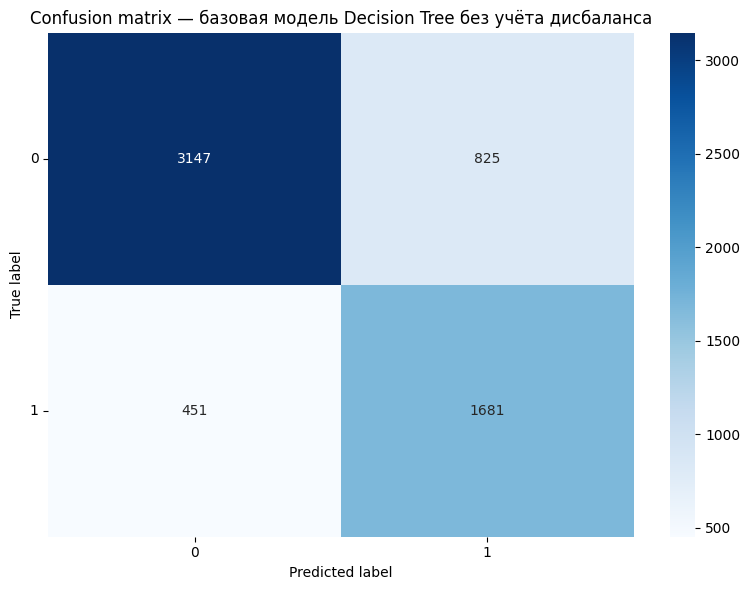

In [33]:
cm_dt = confusion_matrix(y_train, y_pred_dt_base)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion matrix — базовая модель Decision Tree без учёта дисбаланса")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0.5, 1.5], ["0", "1"])
plt.yticks([0.5, 1.5], ["0", "1"], rotation=0)
plt.tight_layout()
plt.show()

Видим, что:

Recall класса 1 = 0.79 => модель пропускает ~21% тяжёлых пациентов.

Precision класса 1 = 0.67 => ложноположительных относительно немного.

Вывод: для медицинской задачи, где пропуск тяжелого пациента может иметь серьезные последствия, Decision Tree уже выглядит предпочтительнее из-за более высокого recall класса 1.

## 2. Взвешивание классов

Чтобы сбалансировать важность классов, присвоим объектам миноритарного класса больший вес. class_weight="balanced" автоматически подберёт необходимое значение.

In [34]:
dt_cw_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("dt", DecisionTreeClassifier(
        random_state=RANDOM_STATE,
        class_weight="balanced"
    ))
])

param_grid_dt_cw = {
    'dt__max_depth': [3, 5, 7, 10, 15, None],
    'dt__min_samples_split': [2, 5, 10, 20],
    'dt__min_samples_leaf': [1, 2, 4, 8],
    'dt__max_leaf_nodes': [10, 20, 50, 100, None],
    'dt__criterion': ['gini', 'entropy']
}

gs_dt_cw = GridSearchCV(
    dt_cw_pipeline,
    param_grid=param_grid_dt_cw,
    cv=skf,
    scoring="recall",
    n_jobs=-1
)

gs_dt_cw.fit(X_train, y_train)
print("Decision Tree с class_weight='balanced'")
print("Лучшие параметры:", gs_dt_cw.best_params_)
print("Лучший recall на кросс-валидации:", gs_dt_cw.best_score_)

Decision Tree с class_weight='balanced'
Лучшие параметры: {'dt__criterion': 'gini', 'dt__max_depth': 7, 'dt__max_leaf_nodes': 50, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 20}
Лучший recall на кросс-валидации: 0.7884674165209838


In [35]:
y_pred_dt_cw = cross_val_predict(
    gs_dt_cw.best_estimator_,
    X_train, y_train,
    cv=skf,
    n_jobs=-1
)

print("\nОтчёт по классам (Decision Tree с class_weight='balanced'):")
print(classification_report(y_train, y_pred_dt_cw))


Отчёт по классам (Decision Tree с class_weight='balanced'):
              precision    recall  f1-score   support

           0       0.87      0.79      0.83      3972
           1       0.67      0.79      0.72      2132

    accuracy                           0.79      6104
   macro avg       0.77      0.79      0.78      6104
weighted avg       0.80      0.79      0.79      6104



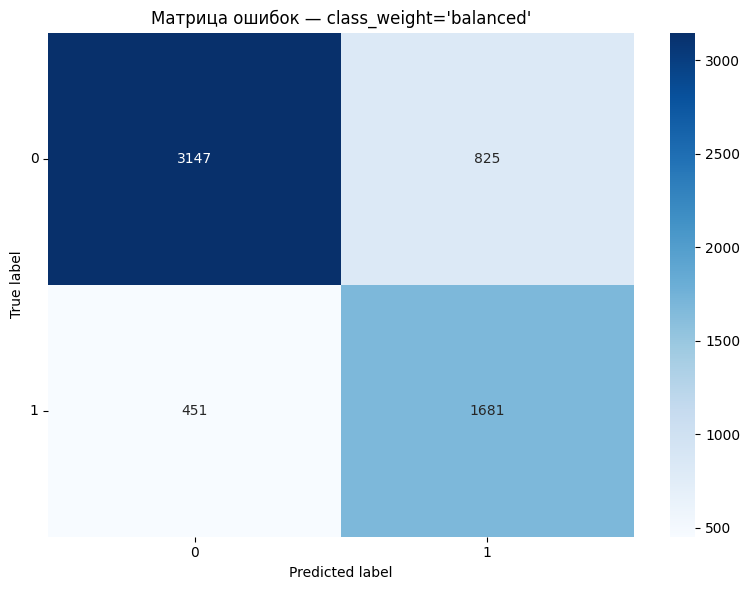

In [36]:
cm_dt_cw = confusion_matrix(y_train, y_pred_dt_cw)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt_cw, annot=True, fmt="d", cmap="Blues")
plt.title("Матрица ошибок — class_weight='balanced'")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0.5, 1.5], ["0", "1"])
plt.yticks([0.5, 1.5], ["0", "1"], rotation=0)
plt.tight_layout()
plt.show()

Видим, что:

Recall класса 1 ~0.8.

Precision класса 1 = 0.67.

Вывод: нет изменений при попытке балансировки классов.

## 3. Downsampling класса большинства

Используем простой способ, чтобы выровнять пропорцию классов: просто удалим некоторые объекты класса большинства.

In [39]:
dt_pipeline_us = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("undersample", RandomUnderSampler(random_state=RANDOM_STATE)),
    ("dt", DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid_dt_us = {
    'dt__max_depth': [3, 5, 7, 10, 15, None],
    'dt__min_samples_split': [2, 5, 10, 20],
    'dt__min_samples_leaf': [1, 2, 4, 8],
    'dt__max_leaf_nodes': [10, 20, 50, 100, None],
    'dt__criterion': ['gini', 'entropy']
}

gs_dt_us = GridSearchCV(
    dt_pipeline_us,
    param_grid=param_grid_dt_us,
    cv=skf,
    scoring="recall",
    n_jobs=-1
)

gs_dt_us.fit(X_train, y_train)
print("RandomDownSampler + Decision Tree")
print("Лучшие параметры:", gs_dt_us.best_params_)
print("Лучший recall на кросс-валидации:", gs_dt_us.best_score_)

RandomDownSampler + Decision Tree
Лучшие параметры: {'dt__criterion': 'entropy', 'dt__max_depth': 3, 'dt__max_leaf_nodes': 10, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 2}
Лучший recall на кросс-валидации: 0.7907983419643544


In [40]:
y_pred_dt_us = cross_val_predict(
    gs_dt_us.best_estimator_,
    X_train, y_train,
    cv=skf,
    n_jobs=-1
)

print("Отчёт по классам (Decision Tree с RandomUnderSampler):")
print(classification_report(y_train, y_pred_dt_us))

Отчёт по классам (Decision Tree с RandomUnderSampler):
              precision    recall  f1-score   support

           0       0.87      0.76      0.81      3972
           1       0.64      0.79      0.71      2132

    accuracy                           0.77      6104
   macro avg       0.76      0.78      0.76      6104
weighted avg       0.79      0.77      0.78      6104



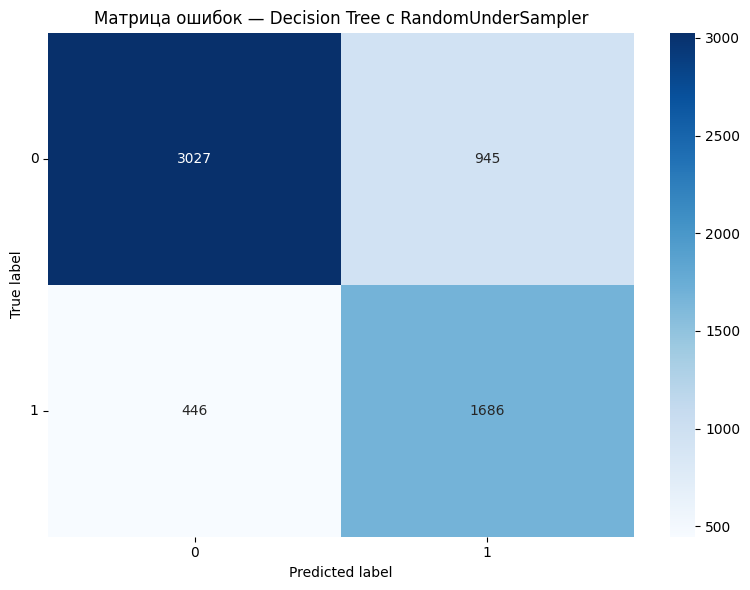

In [41]:
cm_dt_us = confusion_matrix(y_train, y_pred_dt_us)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt_us, annot=True, fmt="d", cmap="Blues")
plt.title("Матрица ошибок — Decision Tree с RandomUnderSampler")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0.5, 1.5], ["0", "1"])
plt.yticks([0.5, 1.5], ["0", "1"], rotation=0)
plt.tight_layout()
plt.show()

Вывод: видим что результаты хуже - немного упал recallprecision класса 1 и снизилась accuracy

## 4. Upsampling класса меньшинства

Теперь поступим наоборот: случайным образом скопируем объекты из класса меньшинства так, чтобы их кол-во приравнять к мажоритарному классу.

In [42]:
dt_pipeline_os = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("oversample", RandomOverSampler(random_state=RANDOM_STATE)),
    ("dt", DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid_dt_os = {
    'dt__max_depth': [3, 5, 7, 10, 15, None],
    'dt__min_samples_split': [2, 5, 10, 20],
    'dt__min_samples_leaf': [1, 2, 4, 8],
    'dt__max_leaf_nodes': [10, 20, 50, 100, None],
    'dt__criterion': ['gini', 'entropy']
}

gs_dt_os = GridSearchCV(
    dt_pipeline_os,
    param_grid=param_grid_dt_os,
    cv=skf,
    scoring="recall",
    n_jobs=-1
)

gs_dt_os.fit(X_train, y_train)
print("RandomOverSampler + Decision Tree")
print("Лучшие параметры:", gs_dt_os.best_params_)
print("Лучший recall на кросс-валидации:", gs_dt_os.best_score_)

RandomOverSampler + Decision Tree
Лучшие параметры: {'dt__criterion': 'gini', 'dt__max_depth': 10, 'dt__max_leaf_nodes': 50, 'dt__min_samples_leaf': 8, 'dt__min_samples_split': 2}
Лучший recall на кросс-валидации: 0.7950313905289661


In [43]:
y_pred_dt_os = cross_val_predict(
    gs_dt_os.best_estimator_,
    X_train, y_train,
    cv=skf,
    n_jobs=-1
)

print("Отчёт по классам (модель с RandomOverSampler):")
print(classification_report(y_train, y_pred_dt_os))

Отчёт по классам (модель с RandomOverSampler):
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      3972
           1       0.68      0.80      0.73      2132

    accuracy                           0.80      6104
   macro avg       0.78      0.80      0.79      6104
weighted avg       0.81      0.80      0.80      6104



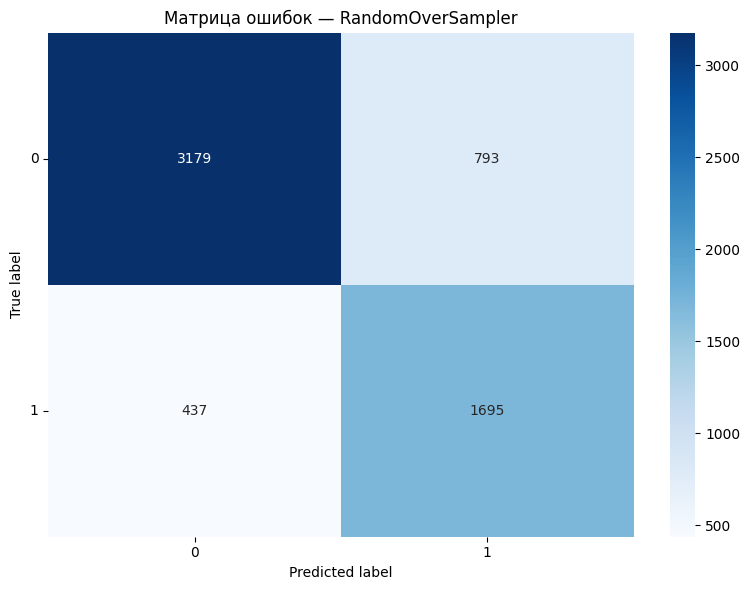

In [44]:
cm_dt_os = confusion_matrix(y_train, y_pred_dt_os)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt_os, annot=True, fmt="d", cmap="Blues")
plt.title("Матрица ошибок — RandomOverSampler")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0.5, 1.5], ["0", "1"])
plt.yticks([0.5, 1.5], ["0", "1"], rotation=0)
plt.tight_layout()
plt.show()

RВывод: RandomOverSampler дал небольшое, но стабильное улучшение по всем метрикам

## 5. SMOTE

Генерация синтетических объектов класса меньшинства.

In [46]:
dt_pipeline_smote = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", SMOTE(random_state=RANDOM_STATE, k_neighbors=5)),
    ("dt", DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid_dt_smote = {
    'dt__max_depth': [3, 5, 7, 10, 15, None],
    'dt__min_samples_split': [2, 5, 10, 20],
    'dt__min_samples_leaf': [1, 2, 4, 8],
    'dt__max_leaf_nodes': [10, 20, 50, 100, None],
    'dt__criterion': ['gini', 'entropy']
}

gs_dt_smote = GridSearchCV(
    dt_pipeline_smote,
    param_grid=param_grid_dt_smote,
    cv=skf,
    scoring="recall",
    n_jobs=-1
)

gs_dt_smote.fit(X_train, y_train)
print("SMOTE + Decision Tree")
print("Лучшие параметры:", gs_dt_smote.best_params_)
print("Лучший recall на кросс-валидации:", gs_dt_smote.best_score_)

SMOTE + Decision Tree
Лучшие параметры: {'dt__criterion': 'gini', 'dt__max_depth': 10, 'dt__max_leaf_nodes': 50, 'dt__min_samples_leaf': 4, 'dt__min_samples_split': 2}
Лучший recall на кросс-валидации: 0.7509648052247913


In [47]:
y_pred_dt_smote = cross_val_predict(
    gs_dt_smote.best_estimator_,
    X_train, y_train,
    cv=skf,
    n_jobs=-1
)

print("Отчёт по классам (модель SMOTE):")
print(classification_report(y_train, y_pred_dt_smote))

Отчёт по классам (модель SMOTE):
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      3972
           1       0.72      0.75      0.74      2132

    accuracy                           0.81      6104
   macro avg       0.79      0.80      0.79      6104
weighted avg       0.81      0.81      0.81      6104



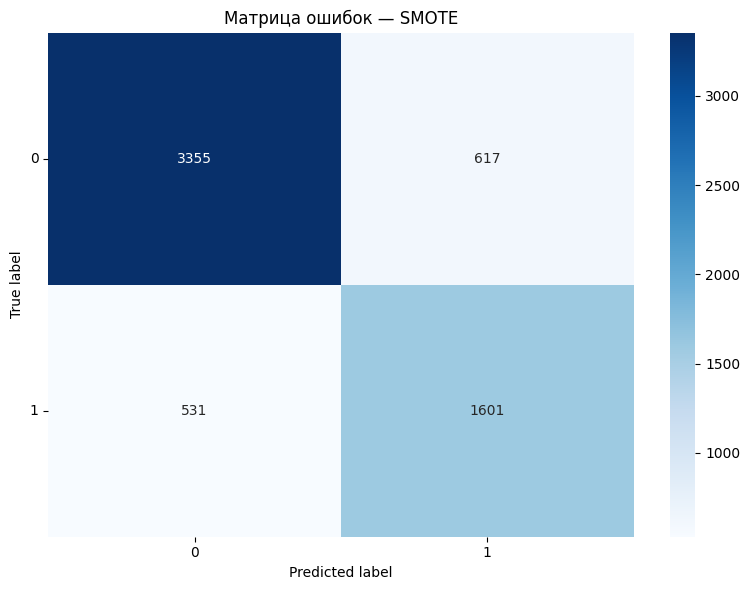

In [48]:
cm_dt_smote = confusion_matrix(y_train, y_pred_dt_smote)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt_smote, annot=True, fmt="d", cmap="Blues")
plt.title("Матрица ошибок — SMOTE")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0.5, 1.5], ["0", "1"])
plt.yticks([0.5, 1.5], ["0", "1"], rotation=0)
plt.tight_layout()
plt.show()

Вывод: SMOTE создает более "качественные" синтетические примеры - меньше ложных срабатываний. Но при этом теряет в recall - мы обнаруживаем меньше тяжелых пациентов. Пока это лучший баланс precision/recall среди всех методов

## Промежуточный вывод

1. RandomOverSampler: Увеличил recall до 0.80 (+1% к базовому)
2. SMOTE: Достиг лучшего precision (0.72)
3. class_weight: Не дал эффекта - метрики идентичны базовой модели
4. RandomUnderSampler: Наихудший результат по precision (0.64)

Медицинская интерпретация:
1. RandomOverSampler: Обнаруживает 80% тяжелых пациентов, но с 32% ложных срабатываний
2. SMOTE: Обнаруживает 75% тяжелых пациентов с лучшей точностью (28% ложных срабатываний)
3. Базовый DT: Промежуточный вариант - 79% обнаружения, 33% ложных срабатываний

В контексте задачи пока что лучше всего себя показывают 2 варианта:
1. Decision Tree + RandomOverSampler (recall = 0.80)
2. Decision Tree + SMOTE (precision = 0.72)

## 6. Random Forest

В качестве основной модели попробуем выбрать модель Random Forest

In [50]:
rf_base_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("rf", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
])

param_grid_rf_base = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [5, 10, 15, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2', None],
    'rf__bootstrap': [True, False],
    'rf__class_weight': [None, 'balanced']
}

gs_rf_base = GridSearchCV(
    rf_base_pipeline,
    param_grid=param_grid_rf_base,
    cv=skf,
    scoring="recall",
    n_jobs=-1
)

gs_rf_base.fit(X_train, y_train)
print("Базовый Random Forest")
print("Лучшие параметры:", gs_rf_base.best_params_)
print("Лучший recall на кросс-валидации:", gs_rf_base.best_score_)

Базовый Random Forest
Лучшие параметры: {'rf__bootstrap': False, 'rf__class_weight': 'balanced', 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 2, 'rf__n_estimators': 50}
Лучший recall на кросс-валидации: 0.8015986630163494


In [51]:
y_pred_rf_base = cross_val_predict(
    gs_rf_base.best_estimator_,
    X_train, y_train,
    cv=skf,
    n_jobs=-1
)

print("\nОтчёт по классам (Базовый Random Forest):")
print(classification_report(y_train, y_pred_rf_base))


Отчёт по классам (Базовый Random Forest):
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      3972
           1       0.72      0.80      0.76      2132

    accuracy                           0.82      6104
   macro avg       0.80      0.82      0.81      6104
weighted avg       0.83      0.82      0.82      6104



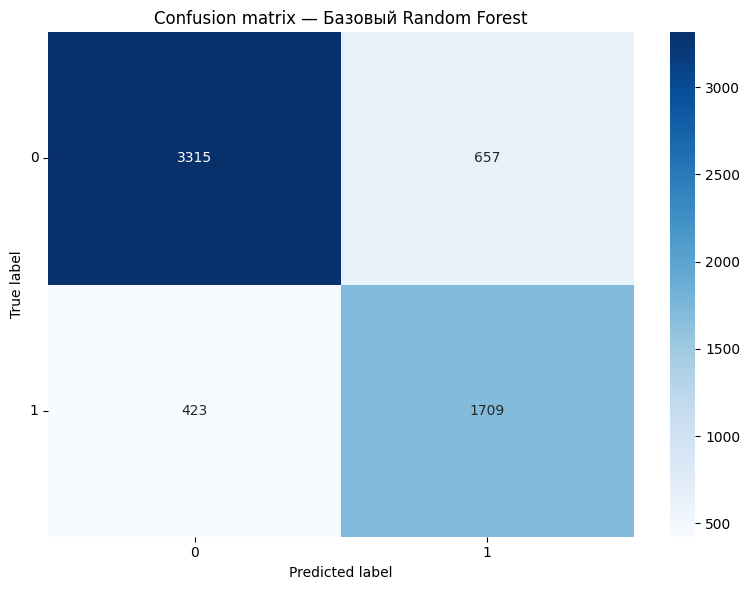

In [52]:
cm_rf_base = confusion_matrix(y_train, y_pred_rf_base)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf_base, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion matrix — Базовый Random Forest")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0.5, 1.5], ["0", "1"])
plt.yticks([0.5, 1.5], ["0", "1"], rotation=0)
plt.tight_layout()
plt.show()

Вывод: Random Forest показывает улучшение по всем метрикам.

1. Обнаруживает 80% тяжелых пациентов (как лучшая DT модель)
2. Только 28% ложных срабатываний (лучше чем у DT)
3. Наилучший баланс между обнаружением и точностью диагноза

Т.к. при обучении с помощью модели Decision Tree лучше всего себя показали RandomOverSampler и SMOTE попробуем применить именно их к Random Forest

## Random Forest + RandomOverSampler

In [53]:
rf_pipeline_os = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("oversample", RandomOverSampler(random_state=RANDOM_STATE)),
    ("rf", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
])

param_grid_rf_os = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [5, 10, 15, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__max_features': ['sqrt', 'log2']
}

gs_rf_os = GridSearchCV(
    rf_pipeline_os,
    param_grid=param_grid_rf_os,
    cv=skf,
    scoring="recall",
    n_jobs=-1
)

gs_rf_os.fit(X_train, y_train)
print("RandomOverSampler + Random Forest")
print("Лучшие параметры:", gs_rf_os.best_params_)
print("Лучший recall на кросс-валидации:", gs_rf_os.best_score_)

RandomOverSampler + Random Forest
Лучшие параметры: {'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__min_samples_split': 5, 'rf__n_estimators': 50}
Лучший recall на кросс-валидации: 0.7955074710558433


In [54]:
y_pred_rf_os = cross_val_predict(
    gs_rf_os.best_estimator_,
    X_train, y_train,
    cv=skf,
    n_jobs=-1
)

print("\nОтчёт по классам (Random Forest + RandomOverSampler):")
print(classification_report(y_train, y_pred_rf_os))


Отчёт по классам (Random Forest + RandomOverSampler):
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      3972
           1       0.73      0.80      0.76      2132

    accuracy                           0.83      6104
   macro avg       0.81      0.82      0.81      6104
weighted avg       0.83      0.83      0.83      6104



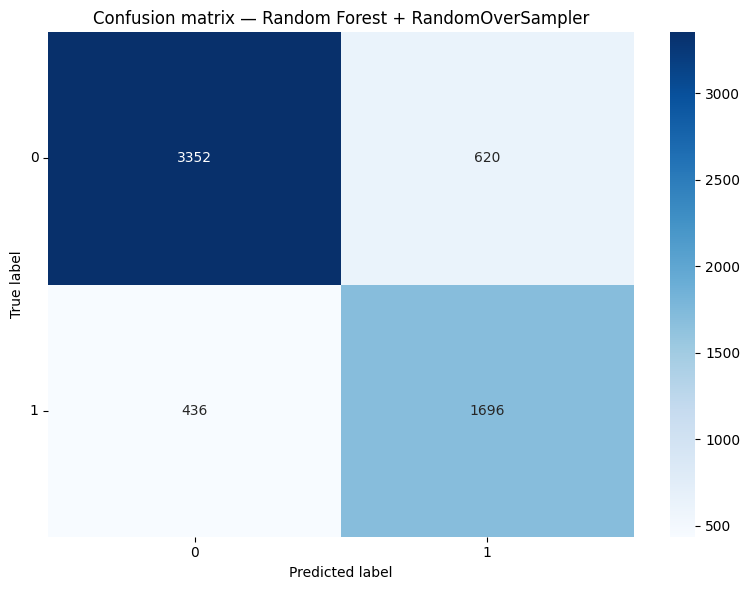

In [57]:
cm_rf_os = confusion_matrix(y_train, y_pred_rf_os)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf_os, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion matrix — Random Forest + RandomOverSampler")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0.5, 1.5], ["0", "1"])
plt.yticks([0.5, 1.5], ["0", "1"], rotation=0)
plt.tight_layout()
plt.show()

## Random Forest + SMOTE

In [55]:
rf_pipeline_smote = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", SMOTE(random_state=RANDOM_STATE, k_neighbors=5)),
    ("rf", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
])

param_grid_rf_smote = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [5, 10, 15, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__max_features': ['sqrt', 'log2']
}

gs_rf_smote = GridSearchCV(
    rf_pipeline_smote,
    param_grid=param_grid_rf_smote,
    cv=skf,
    scoring="recall",
    n_jobs=-1,
    verbose=1
)

gs_rf_smote.fit(X_train, y_train)
print("SMOTE + Random Forest")
print("Лучшие параметры:", gs_rf_smote.best_params_)
print("Лучший recall на кросс-валидации:", gs_rf_smote.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
SMOTE + Random Forest
Лучшие параметры: {'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__min_samples_split': 10, 'rf__n_estimators': 200}
Лучший recall на кросс-валидации: 0.7711119174060758


In [56]:
y_pred_rf_smote = cross_val_predict(
    gs_rf_smote.best_estimator_,
    X_train, y_train,
    cv=skf,
    n_jobs=-1
)

print("\nОтчёт по классам (Random Forest + SMOTE):")
print(classification_report(y_train, y_pred_rf_smote))


Отчёт по классам (Random Forest + SMOTE):
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      3972
           1       0.74      0.77      0.76      2132

    accuracy                           0.83      6104
   macro avg       0.81      0.81      0.81      6104
weighted avg       0.83      0.83      0.83      6104



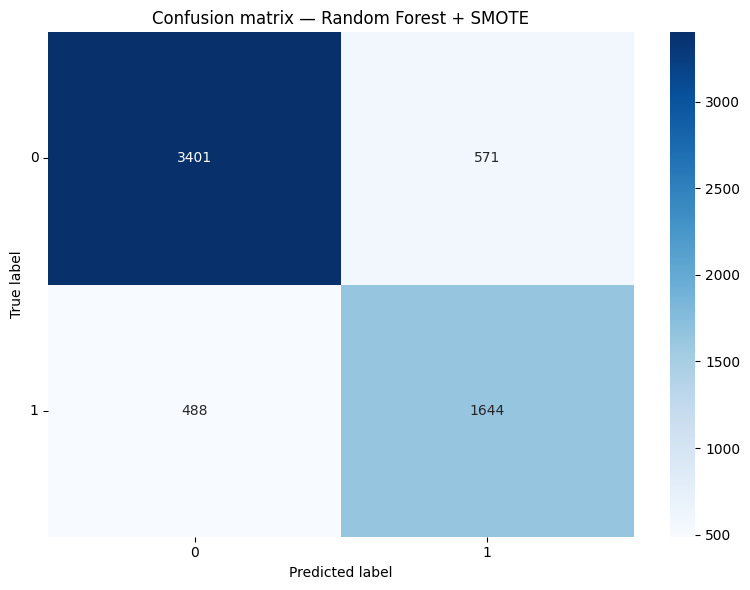

In [58]:
cm_rf_smote = confusion_matrix(y_train, y_pred_rf_smote)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf_smote, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion matrix — Random Forest + SMOTE")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0.5, 1.5], ["0", "1"])
plt.yticks([0.5, 1.5], ["0", "1"], rotation=0)
plt.tight_layout()
plt.show()

Вывод: лучше всего себя показала базовая модель Random Forest:
1. Оригинальные данные более репрезентативны
2. Синтетические примеры могут искажать реальные закономерности
3. Лучше использовать встроенные методы балансировки (class_weight)

# Этап III. Проверка на тесте

Обучаем лучшую модель на всём трейне, строим график feature importances и делаем предикт для теста.

In [59]:
best_params = gs_rf_base.best_params_
print(f"Лучшие параметры: {best_params}")

Лучшие параметры: {'rf__bootstrap': False, 'rf__class_weight': 'balanced', 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 2, 'rf__n_estimators': 50}


In [60]:
final_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("rf", RandomForestClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1,
        bootstrap=best_params["rf__bootstrap"],
        class_weight=best_params["rf__class_weight"],
        max_depth=best_params["rf__max_depth"],
        max_features=best_params["rf__max_features"],
        min_samples_leaf=best_params["rf__min_samples_leaf"],
        min_samples_split=best_params["rf__min_samples_split"],
        n_estimators=best_params["rf__n_estimators"]
    ))
])

# обучение на всём train
final_pipeline.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_skewed', ...), ('num_symmetric', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [61]:
preprocess_step = final_pipeline.named_steps["preprocess"]
feature_names = preprocess_step.get_feature_names_out()

# важность признаков из Random Forest
rf_step = final_pipeline.named_steps["rf"]
importances = rf_step.feature_importances_

# формируем таблицу feature importances
fi = (
    pd.DataFrame({"feature": feature_names, "importance": importances})
      .sort_values("importance", ascending=False)
)

C:\Users\sulta\AppData\Local\Temp\ipykernel_5056\940404143.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fi.head(TOP_N), x="importance", y="feature", palette="viridis")


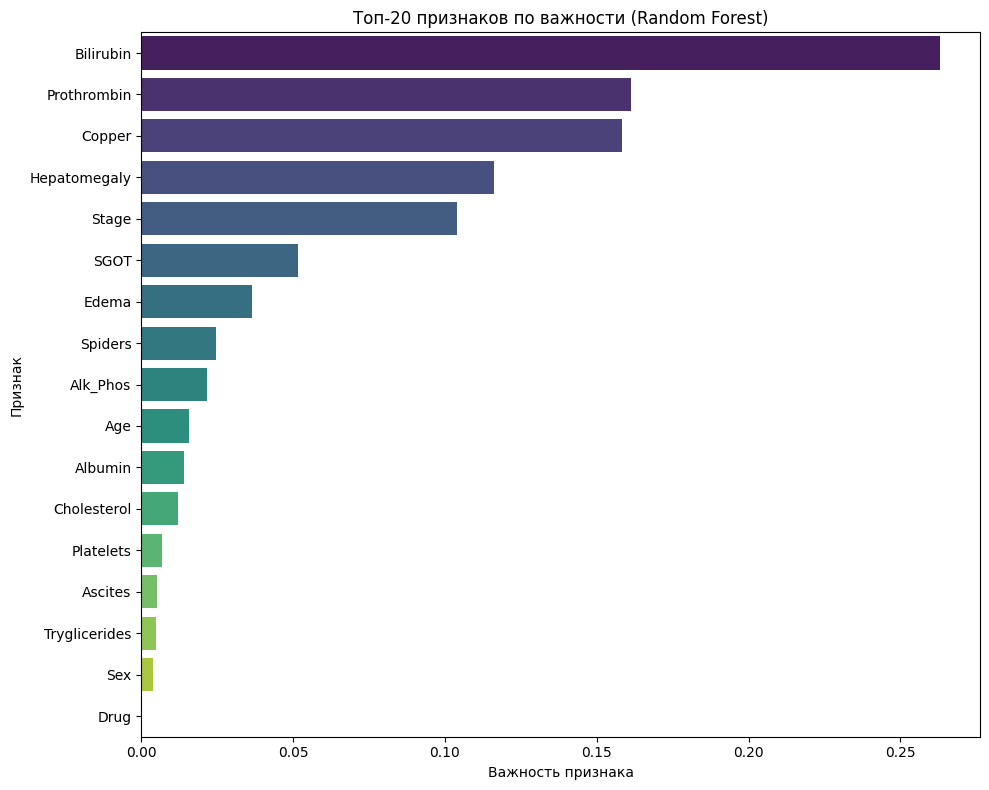

In [62]:
TOP_N = 20

plt.figure(figsize=(10, 8))
sns.barplot(data=fi.head(TOP_N), x="importance", y="feature", palette="viridis")
plt.xlabel("Важность признака")
plt.ylabel("Признак")
plt.title(f"Топ-{TOP_N} признаков по важности (Random Forest)")
plt.tight_layout()
plt.show()

Топ-5 самых важных медицинских показателей:
1. Bilirubin - самый значимый маркер
2. Prothrombin
3. Copper
4. Hepatomegaly
5. Stage

Модель правильно выделила клинически значимые маркеры печеночной функции, что подтверждает ее адекватность для медицинской диагностики.

ROC AUC АНАЛИЗ НА TEST SET:
ROC AUC: 0.8920


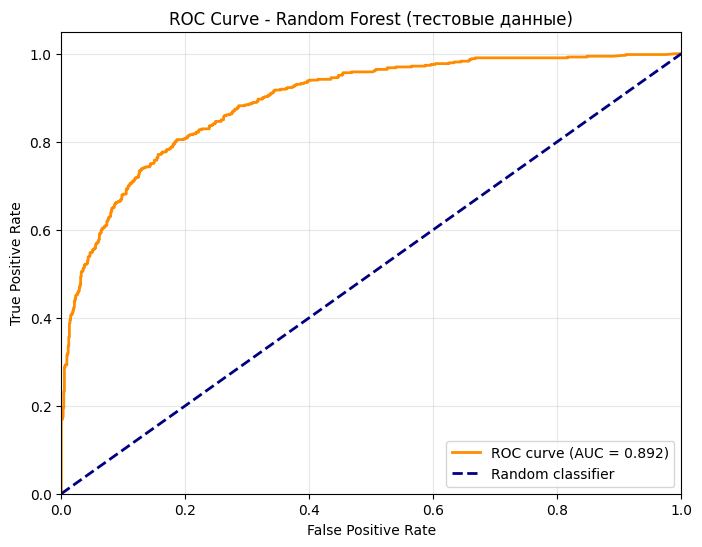

In [64]:
# Предсказания на тестовых данных
y_test_pred = final_pipeline.predict(X_test)
y_test_proba = final_pipeline.predict_proba(X_test)

# Рассчитываем ROC AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:, 1])
roc_auc = auc(fpr, tpr)

print("="*60)
print("ROC AUC АНАЛИЗ НА TEST SET:")
print("="*60)
print(f"ROC AUC: {roc_auc:.4f}")

# Визуализация ROC кривой
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest (тестовые данные)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

ROC AUC на train: 0.9079
ROC AUC на test:  0.8920


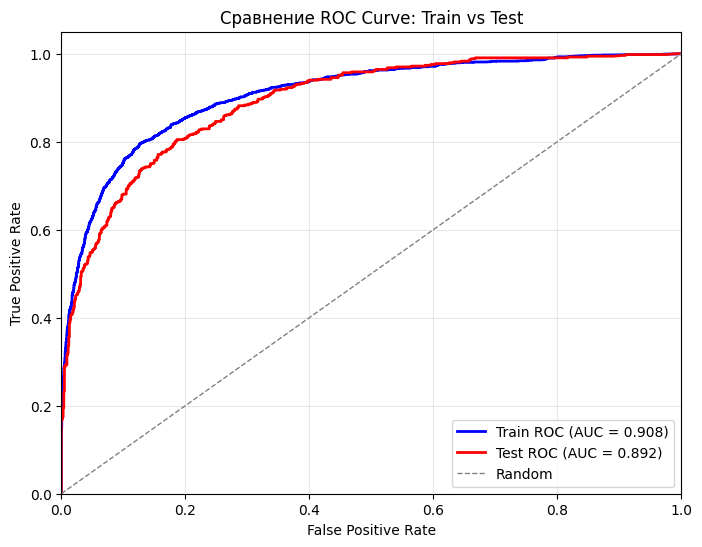

In [65]:
# ROC AUC на тренировочных данных для сравнения
y_train_proba = final_pipeline.predict_proba(X_train)
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba[:, 1])
roc_auc_train = auc(fpr_train, tpr_train)

print(f"ROC AUC на train: {roc_auc_train:.4f}")
print(f"ROC AUC на test:  {roc_auc:.4f}")

# Сравнительная визуализация
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, 
         label=f'Train ROC (AUC = {roc_auc_train:.3f})')
plt.plot(fpr, tpr, color='red', lw=2, 
         label=f'Test ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Сравнение ROC Curve: Train vs Test')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

Выводы:
1. Отличная стабильность модели. Разница всего 0.016 - минимальное переобучение
2. Высокое качество классификации. Модель в 89% случаев правильно отличает больных от здоровых
3. Хорошая обобщающая способность. Кривые train и test почти совпадают. Результаты воспроизводимы на новых данных

In [66]:
THRESHOLD = 0.3

y_proba_test = final_pipeline.predict_proba(X_test)[:, 1]
y_pred_test = (y_proba_test >= THRESHOLD).astype(int)

In [67]:
print(f"Отчёт по классам на тесте (threshold={THRESHOLD}):")
print(classification_report(y_test, y_pred_test))

Отчёт по классам на тесте (threshold=0.3):
              precision    recall  f1-score   support

           0       0.94      0.61      0.74       993
           1       0.56      0.93      0.70       533

    accuracy                           0.72      1526
   macro avg       0.75      0.77      0.72      1526
weighted avg       0.81      0.72      0.73      1526



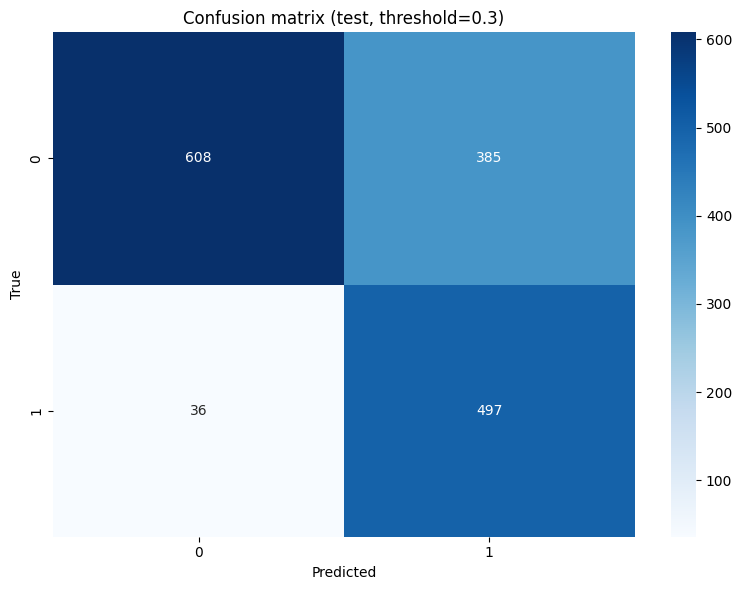

In [68]:
cm_test = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion matrix (test, threshold=0.3)")
plt.tight_layout()
plt.show()

Краткие выводы по результатам с порогом 0.3:
ПРЕИМУЩЕСТВА:
1. Recall 93% - обнаруживаем почти всех тяжелых пациентов
2. Только 36 пропущенных из 533 больных
3. 608 здоровых правильно идентифицированы

НЕДОСТАТКИ:
1. Precision 56% - каждый второй "подозрительный" требует перепроверки
2. 385 ложных тревог - дополнительная нагрузка на систему
3. Accuracy 72% - общая точность снижена ради обнаружения больных

МЕДИЦИНСКАЯ ЦЕННОСТЬ:
1. Главная цель "не пропустить больных" достигнута на 93%
2. Ложные тревоги - приемлемая цена за спасенные жизни
3. На каждые 100 больных обнаруживаем 93, ценой 72 ложных тревог

## Выводы

**Предобработка:**

Для числовых признаков применена стратегия log-преобразование → клиппинг выбросов. Бинарные признаки закодированы в 0/1, категориальные — с помощью OrdinalEncoder. Масштабирование не применялось, так как tree-модели не чувствительны к масштабу признаков.

**Моделирование:**

Проведено сравнение Decision Tree и Random Forest с различными методами борьбы с дисбалансом. Наилучшие результаты показал Random Forest с автоматической балансировкой классов (class_weight='balanced'). Дополнительная настройка порога классификации до 0.3 значительно повысила чувствительность модели к классу тяжелых пациентов.

**Результаты:**

На тестовой выборке модель демонстрирует recall класса 1 = 0.93 при precision = 0.56, что делает её оптимальным решением для задач скрининга, где критически важно не пропустить тяжелых пациентов. Наиболее информативными признаками оказались Bilirubin, Prothrombin, Copper, Hepatomegaly и Stage, что соответствует медицинской логике диагностики заболеваний печени.